In [1]:
from os import path
import numpy as np
import matplotlib.pyplot as plt

import jampy as jampy_package
from jampy.jam_axi_intr import jam_axi_intr

In [2]:
def satoh_solution(R, z, beta):
    """
    Implements the analytic Jeans solution of eq.(68)-(69) from
    `Cappellari (2020) <https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C>`_

    """
    G = 0.004301  # (km/s)^2 pc/Msun [6.674e-11 SI units (CODATA-14)]
    a = b = M = 1

    Q = np.sqrt(b**2 + z**2)
    S = np.sqrt(a**2 + 2*a*Q + R**2 + z**2)
    sig2z = G*M*Q*(a + 2*Q)/(3*Q*(a + 2*Q) + S**2)/(2*S)        # eq.(68)
    v2phi = sig2z*(1 - 6*(R/S)**2)/(1 - beta) + G*M*R**2/S**3   # eq.(69)

    return sig2z, v2phi



In [3]:
def jam_axi_intr_example():
    """
    Usage example for jam_axi_intr().
    It takes about 1s on a 3GHz CPU.
    I use as "data" the anisotropic cylindrical solution
    from Cappellari (2020, MNRAS) for the density by Satoh (1980).
    The MGE fit is from Table 1 of the above paper
    https://ui.adsabs.harvard.edu/abs/2020MNRAS.494.4819C

    """
    rr = np.linspace(0, 16, 32)
    zz = np.linspace(0, 6, 12)
    Rbin, zbin = map(np.ravel, np.meshgrid(rr, zz))
    w = (Rbin == 0) & (zbin == 0)
    Rbin, zbin = Rbin[~w], zbin[~w]  # Remove central singularity
    jampy_dir = path.dirname(path.realpath(jampy_package.__file__))
    log_dens_lum, log_sigma_lum, qintr_lum = np.loadtxt(jampy_dir + '/examples/cappellari2020_table1.txt', unpack=True)
    dens_lum, sigma_lum = 10**log_dens_lum, 10**log_sigma_lum

    beta0 = -0.78
    sig2z, v2phi = satoh_solution(Rbin, zbin, beta0)

    gamma0 = 0.78
    beta = np.full_like(dens_lum, beta0)
    gamma = np.full_like(dens_lum, gamma0)

    dens_pot = dens_lum
    sigma_pot = sigma_lum
    qintr_pot = qintr_lum

    mbh = 0
    sig2R = sig2z/(1 - beta0)
    sig2phi = sig2R*(1- gamma0)
    data = np.sqrt([sig2R, sig2z, sig2phi, v2phi])
    errors = np.full_like(data, 5.28e-5)  # make chi2 = 1

    jam = jam_axi_intr(dens_lum, sigma_lum, qintr_lum, dens_pot, sigma_pot, qintr_pot,
                        mbh, Rbin, zbin, beta=beta, gamma=gamma, align='cyl',
                        plot=1, data=data, errors=errors, ml=-1)

    print(f"M/L = {jam.ml:.3f}; chi2 = {jam.chi2:.3f}")

    plt.pause(1)


Perform interpolation


/Users/alonakonst/.local/share/virtualenvs/Code-xJh5Zfm5/lib/python3.8/site-packages/jampy/jam_axi_intr.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  R, z, sigma_lum, sigma_pot = np.array([R, z, sigma_lum, sigma_pot])/scale


jam_axi_cyl_intr elapsed time (sec): 0.87
M/L = 1.006; chi2 = 1.000


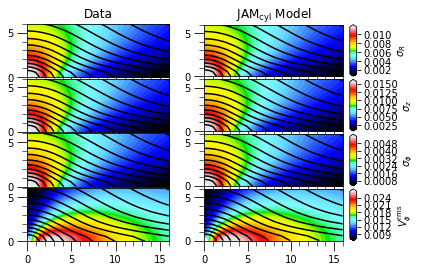

In [4]:

if __name__ == '__main__':

    jam_axi_intr_example()